In [23]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization

In [29]:
BASE_PATH = "Oxford-IIIT Pet\images"
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
IMAGE_SIZE = (256, 256)
RANDOM_STATE = 7
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.8, 0.1, 0.1

In [25]:
import tarfile
tar = tarfile.open("drive/MyDrive/dataset/annotations.tar.gz")
tar.extractall()
tar.close()

In [26]:
import os
from PIL import Image
folder_path = 'drive/MyDrive/images'
extensions = []
corupt_img_paths=[]
for fldr in os.listdir(folder_path):
        file_path = os.path.join(folder_path, fldr)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        try:
            im = Image.open(file_path)
        except:
            print(file_path)
            os.remove(file_path)
            continue
        else:
            rgb_im = im.convert('RGB')
            if fldr.split('.')[1] not in extensions:
                extensions.append(fldr.split('.')[1])

In [27]:
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.0001
PLOTS_DPI = 200

In [31]:
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join('drive/MyDrive/images', '*.jpg'))]

print(f"\nTotal number of image files: {len(imageNames)}")


Total number of image files: 2256


In [32]:
labels = [' '.join(name.split('_')[:-1]) for name in imageNames ]

print(f"\nTotal number of unique labels: {len(np.unique(labels))}")


Total number of unique labels: 37


In [33]:
labelEncDict = {name : ind for ind, name in enumerate(np.unique(labels))}
for k, v in labelEncDict.items():
    print(f"{k:32} : {v}")

Abyssinian                       : 0
Bengal                           : 1
Birman                           : 2
Bombay                           : 3
British Shorthair                : 4
Egyptian Mau                     : 5
Maine Coon                       : 6
Persian                          : 7
Ragdoll                          : 8
Russian Blue                     : 9
Siamese                          : 10
Sphynx                           : 11
american bulldog                 : 12
american pit bull terrier        : 13
basset hound                     : 14
beagle                           : 15
boxer                            : 16
chihuahua                        : 17
english cocker spaniel           : 18
english setter                   : 19
german shorthaired               : 20
great pyrenees                   : 21
havanese                         : 22
japanese chin                    : 23
keeshond                         : 24
leonberger                       : 25
miniature pinscher    

In [36]:
labelDecDict = {ind: name for name, ind in labelEncDict.items()}
for k, v in labelDecDict.items():
    print(f"{k:3} : {v}")

  0 : Abyssinian
  1 : Bengal
  2 : Birman
  3 : Bombay
  4 : British Shorthair
  5 : Egyptian Mau
  6 : Maine Coon
  7 : Persian
  8 : Ragdoll
  9 : Russian Blue
 10 : Siamese
 11 : Sphynx
 12 : american bulldog
 13 : american pit bull terrier
 14 : basset hound
 15 : beagle
 16 : boxer
 17 : chihuahua
 18 : english cocker spaniel
 19 : english setter
 20 : german shorthaired
 21 : great pyrenees
 22 : havanese
 23 : japanese chin
 24 : keeshond
 25 : leonberger
 26 : miniature pinscher
 27 : newfoundland
 28 : pomeranian
 29 : pug
 30 : saint bernard
 31 : samoyed
 32 : scottish terrier
 33 : shiba inu
 34 : staffordshire bull terrier
 35 : wheaten terrier
 36 : yorkshire terrier


In [37]:
for i in labelEncDict.keys():
    print(f"{i:32} : {labels.count(i)}")

Abyssinian                       : 69
Bengal                           : 54
Birman                           : 59
Bombay                           : 63
British Shorthair                : 75
Egyptian Mau                     : 62
Maine Coon                       : 60
Persian                          : 54
Ragdoll                          : 80
Russian Blue                     : 60
Siamese                          : 45
Sphynx                           : 51
american bulldog                 : 62
american pit bull terrier        : 60
basset hound                     : 61
beagle                           : 63
boxer                            : 58
chihuahua                        : 62
english cocker spaniel           : 53
english setter                   : 53
german shorthaired               : 54
great pyrenees                   : 59
havanese                         : 61
japanese chin                    : 56
keeshond                         : 84
leonberger                       : 71
miniature pi

In [40]:

imageData = []

for name in tqdm(imageNames, desc = 'Loading image data', unit = 'drive/MyDrive/images'):
    img = load_img(os.path.join('drive/MyDrive/images', name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)

imageData = np.array(imageData)
imageData.shape

Loading image data: 100%|██████████| 2256/2256 [00:27<00:00, 83.26drive/MyDrive/images/s] 


(2256, 256, 256, 3)

In [41]:
labelsEncoded = list(map(lambda x : labelEncDict.get(x), labels))

for i, l in zip(imageNames[::1000], labelsEncoded[::1000]):
    print(f"{i:32}\t{labelDecDict[l]:32}\t{l}")

saint_bernard_153.jpg           	saint bernard                   	30
pomeranian_87.jpg               	pomeranian                      	28
Abyssinian_219.jpg              	Abyssinian                      	0


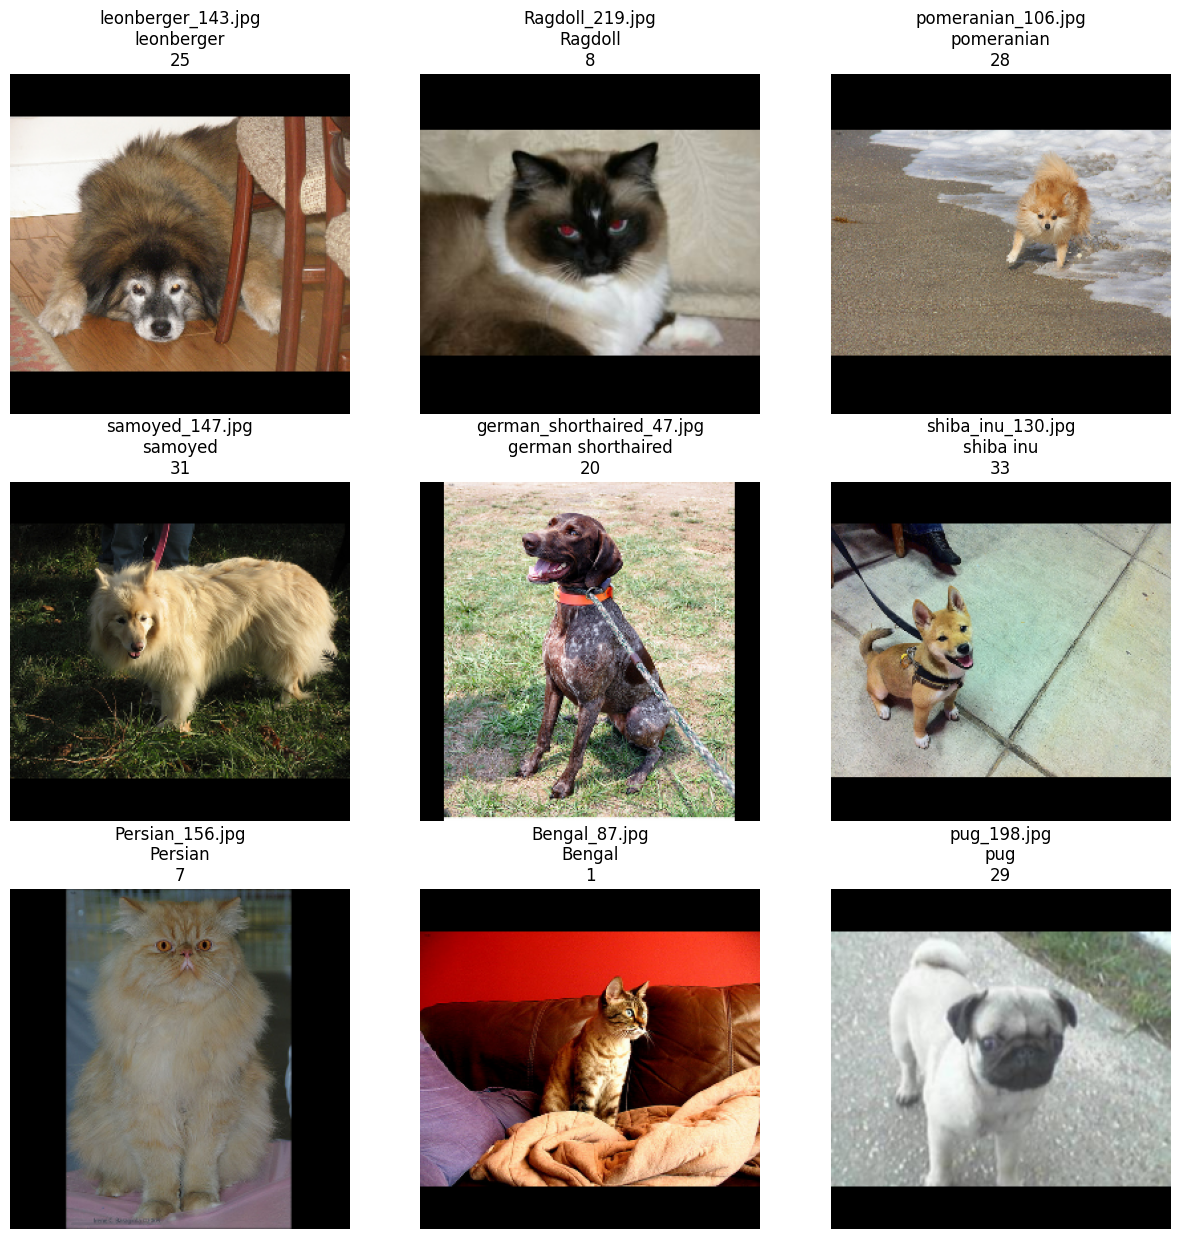

In [42]:
plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))

for i, imgIndex in enumerate(np.random.randint(0, len(imageNames), size = 9)):
  plt.subplot(3, 3, i + 1)
  plt.axis(False)
  plt.grid(False)
  plt.title(f'{imageNames[imgIndex]}\n{labels[imgIndex]}\n{labelsEncoded[imgIndex]}')
  plt.imshow(imageData[imgIndex])
plt.show()

In [43]:
imageData.max()

255

In [44]:
X_tv, X_test, y_tv, y_test = train_test_split(
    imageData,
    labelsEncoded,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = labelsEncoded
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_tv,
    y_tv,
    test_size = VAL_SIZE,
    random_state = RANDOM_STATE,
    stratify = y_tv
    )

print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {len(y_train)}')
print(f'\nValidation Data: {X_val.shape}')
print(f'Validation Labels: {len(y_val)}')
print(f'\nTesting Data: {X_test.shape}')
print(f'Testing Labels: {len(y_test)}')

Training Data: (1827, 256, 256, 3)
Training Labels: 1827

Validation Data: (203, 256, 256, 3)
Validation Labels: 203

Testing Data: (226, 256, 256, 3)
Testing Labels: 226


In [45]:
del imageData
del labelsEncoded
del X_tv
del y_tv

In [46]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data = train_gen.flow(x = X_train, y = y_train, batch_size = BATCH_SIZE, shuffle = True)
len(train_data)

58

In [47]:
val_gen = ImageDataGenerator(rescale = 1./255)
val_data = val_gen.flow(x = X_val, y = y_val, batch_size = BATCH_SIZE, shuffle = True)
len(val_data)

7

In [48]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = X_test, y = y_test, batch_size = BATCH_SIZE)
len(test_data)

8

In [49]:
def plot_generator_images(gen, suptitle, labelDecDict, print_pred = False, model = None, nrows = 3, ncols = 3, figsize = (12, 12)):
    gen_data = gen.next()

    plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.suptitle(suptitle, fontsize = 20)
    plt.tight_layout(rect = [0, 0, 1, 0.96], h_pad = 2)

    if(print_pred and model):
        pred = np.argmax(model.predict(gen_data[0]), axis=1)

    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.axis(False)
        plt.grid(False)

        if(print_pred and pred.any()):
            plt.title(f"True: {labelDecDict[gen_data[1][i]]}\nPredicted: {labelDecDict[pred[i]]}")
        else:
            plt.title(labelDecDict[gen_data[1][i]])
        plt.imshow(gen_data[0][i])

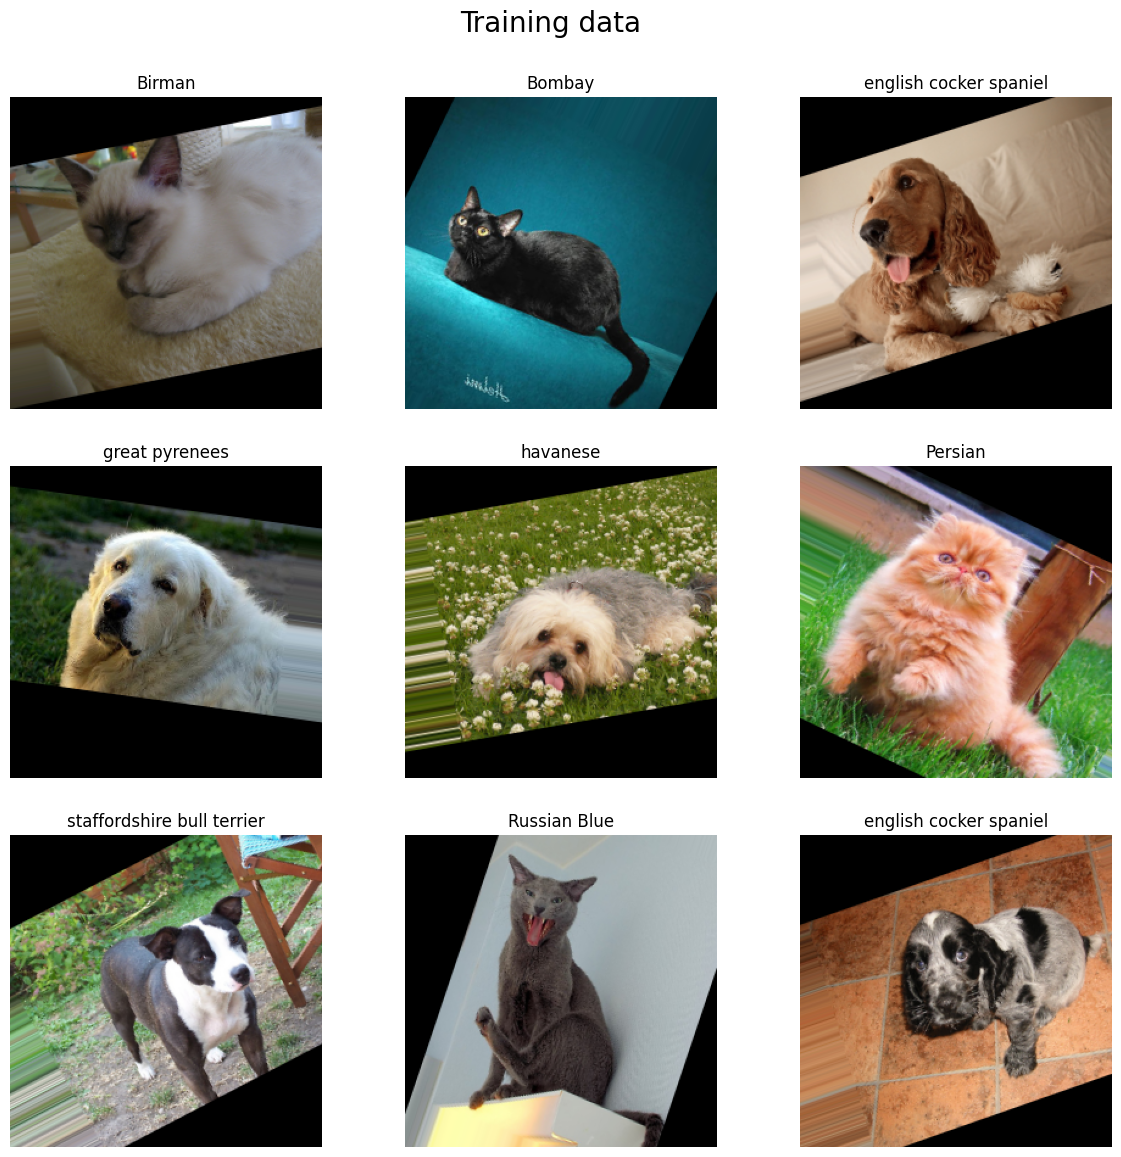

In [50]:
plot_generator_images(train_data, "Training data", labelDecDict)

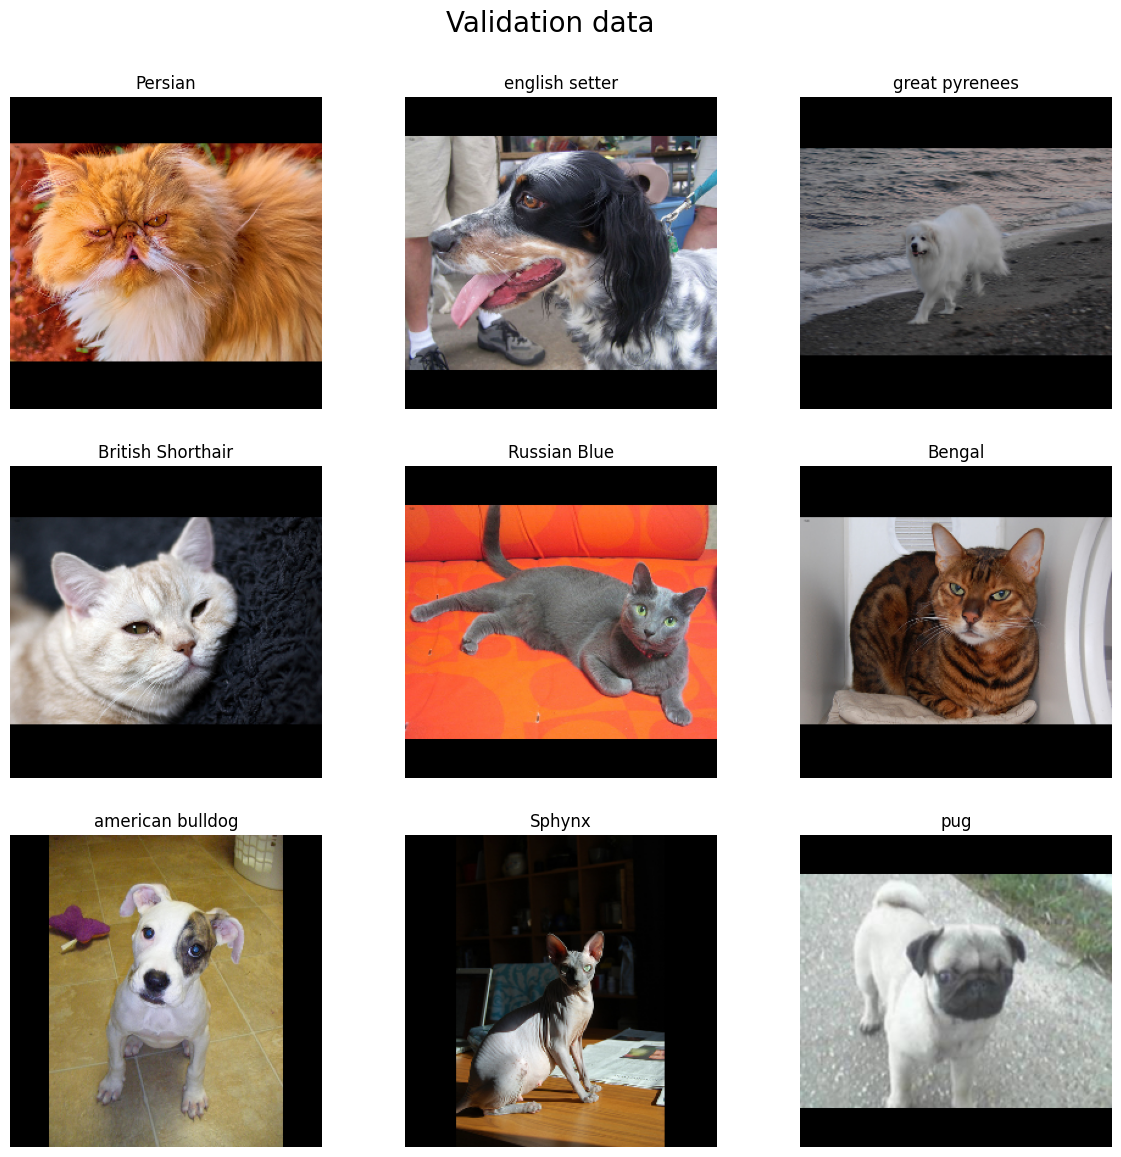

In [51]:
plot_generator_images(val_data, "Validation data", labelDecDict)

In [52]:
model = Sequential([
    Conv2D(32, 5, padding = 'same', input_shape = (*IMAGE_SIZE, 3)),
    Conv2D(32, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(32, 4, padding = 'same'),
    Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(64, 4, padding = 'same'),
    Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, 3, padding = 'same'),
    Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(128, 3, padding = 'same'),
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(128, 2, padding = 'same'),
    Conv2D(128, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(256, 2, padding = 'same'),
    Conv2D(256, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Flatten(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation = 'sigmoid'),
    Dropout(0.2),
    Dense(256, activation = 'sigmoid'),
    Dropout(0.1),
    Dense(len(labelEncDict), activation = 'softmax')
])

model.compile(optimizer = Adam(LEARNING_RATE),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      16416     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                   

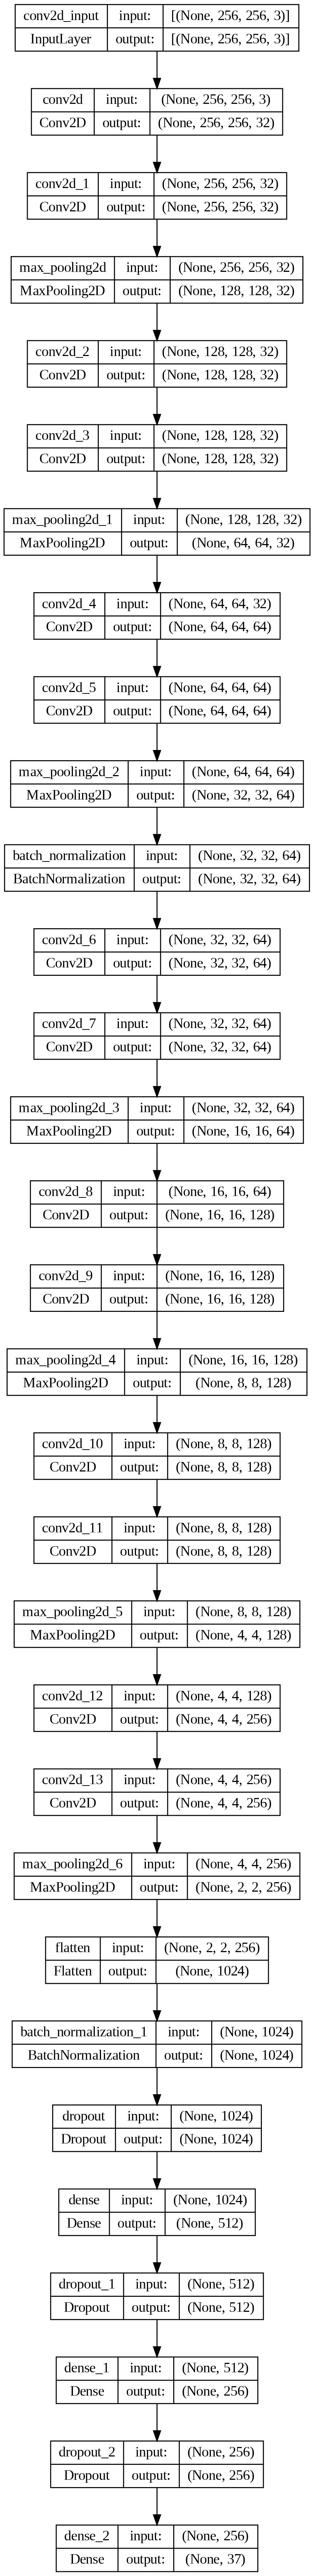

In [54]:
plot_model(model, to_file = 'model.jpg', show_shapes = True, dpi = PLOTS_DPI)

In [55]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 20)

history = model.fit(train_data, validation_data = val_data, epochs = 100, verbose = 1, callbacks = [earlyStop, tensorBoard])

Epoch 1/100
58/58 [==============================] - 1230s 21s/step - loss: 3.7552 - sparse_categorical_accuracy: 0.0208 - val_loss: 3.6337 - val_sparse_categorical_accuracy: 0.0246
Epoch 2/100
58/58 [==============================] - 1213s 21s/step - loss: 3.6020 - sparse_categorical_accuracy: 0.0416 - val_loss: 3.6016 - val_sparse_categorical_accuracy: 0.0394
Epoch 3/100
41/58 [====================>.........] - ETA: 5:31 - loss: 3.5466 - sparse_categorical_accuracy: 0.0538

KeyboardInterrupt: ignored

In [57]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('plots/acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

NameError: ignored

In [ ]:
test_loss, test_acc = model.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")

In [ ]:
plot_generator_images(test_data, "Testing data", labelDecDict, print_pred = True, model = model)

In [ ]:
y_pred = np.argmax(model.predict(X_test/255), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = list(labelEncDict.values())),
                        display_labels = list(labelEncDict.keys())
                        ).plot(ax = ax, xticks_rotation = 'vertical')

plt.savefig('confusion_matrix.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

In [ ]:
model.save('pet_image_classifier')

In [ ]:
saved_model = tf.keras.models.load_model('pet_image_classifier')

sm_test_loss, sm_test_acc = saved_model.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {sm_test_loss}")
print(f"Accuracy on Testing data: {sm_test_acc}")